Ten kod stanowi implementację przykładowego kodu w bibliotece SHAP-a na zbiorze danych [Abalone](https://archive.ics.uci.edu/dataset/1/abalone), zawartą w poniższym [kursie](https://www.youtube.com/watch?v=MQ6fFDwjuco&list=PLqDyyww9y-1SJgMw92x90qPYpHgahDLIK&index=1).
Podczas preprocesing-u zbiór jest dzielony na 3 różne klasy w zależności od wartości y (liczby całkowitej symbolujące liczby pierścieni uchowca). Następnie, po wyliczeniu SHAP values generowanych jest kilka przykładowych wykresów, opisanych poniżej.

##**Setup**##

In [1]:
!pip install shap
!pip install ucimlrepo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 2.8 MB/s eta 0:00:00


In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import shap
shap.initjs()

##**Dataset**##

In [6]:
data = pd.read_csv("/content/abalone.data",
                   names=["sex", "length", "diameter", "height",
                          "whole weight", "shucked weight",
                          "viscera weight", "shell weight",
                          "rings"])
print(len(data))
data.head()


4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


##**Feature engeniring**##

In [7]:
y = data['rings']
X = data[['sex', 'length', 'height', "shucked weight", "viscera weight", "shell weight"]]

In [8]:
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis = 1)

X.head()

<ipython-input-8-fb13e8482289>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
<ipython-input-8-fb13e8482289>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]


,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


##**Training Multiclassmodel**##

In [11]:
y_cat = [2 if y_ > 12 else 1 if y_ > 8 else 0 for y_ in y]

model_cat = xgb.XGBClassifier(objective="binary:logistic")
model_cat.fit(X, y_cat)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [12]:
model_cat.predict_proba(X)[0]

array([0.29758084, 0.19655095, 0.50586826], dtype=float32)

In [13]:
explainer = shap.Explainer(model_cat)
shap_values_cat = explainer(X)

print(np.shape(shap_values_cat))

(4177, 8, 3)


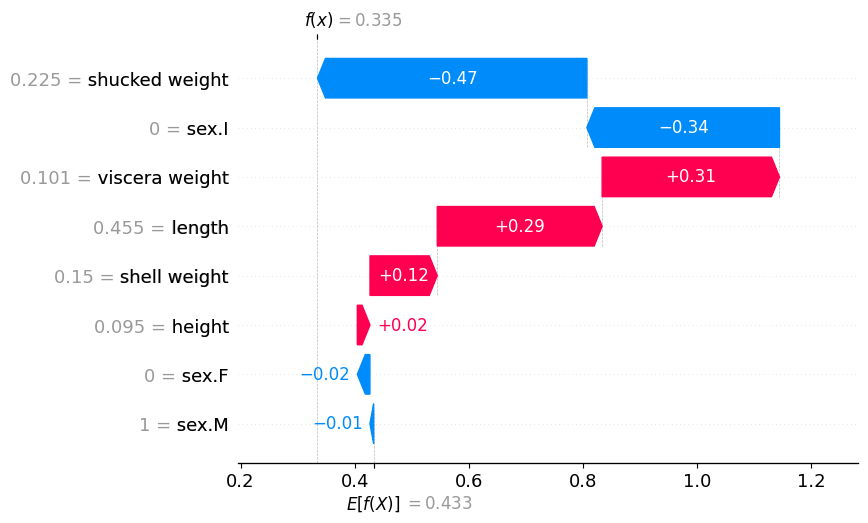

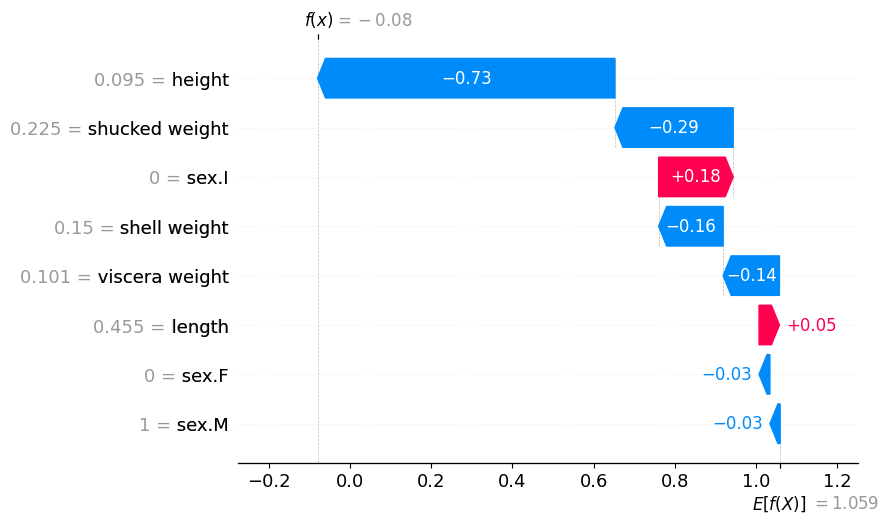

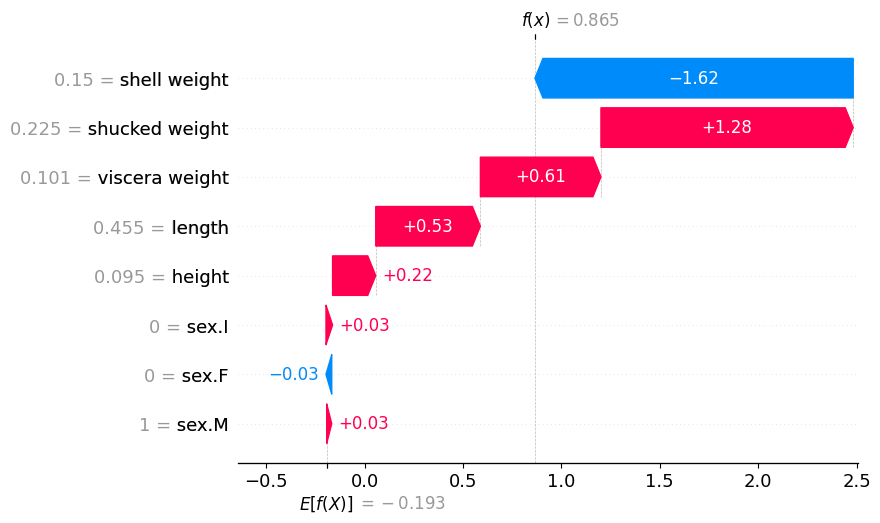

In [14]:
#Wykres waterfall dla pierwszej obserwacji (klasa 1)
shap.plots.waterfall(shap_values_cat[0, :, 0])

#Wykres waterfall dla pierwszej obserwacji (klasa 2)
shap.plots.waterfall(shap_values_cat[0, :, 1])

#Wykres waterfall dla pierwszej obserwacji (klasa 3)
shap.plots.waterfall(shap_values_cat[0, :, 2])

In [15]:
def softmax(x) :
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum(axis=0)

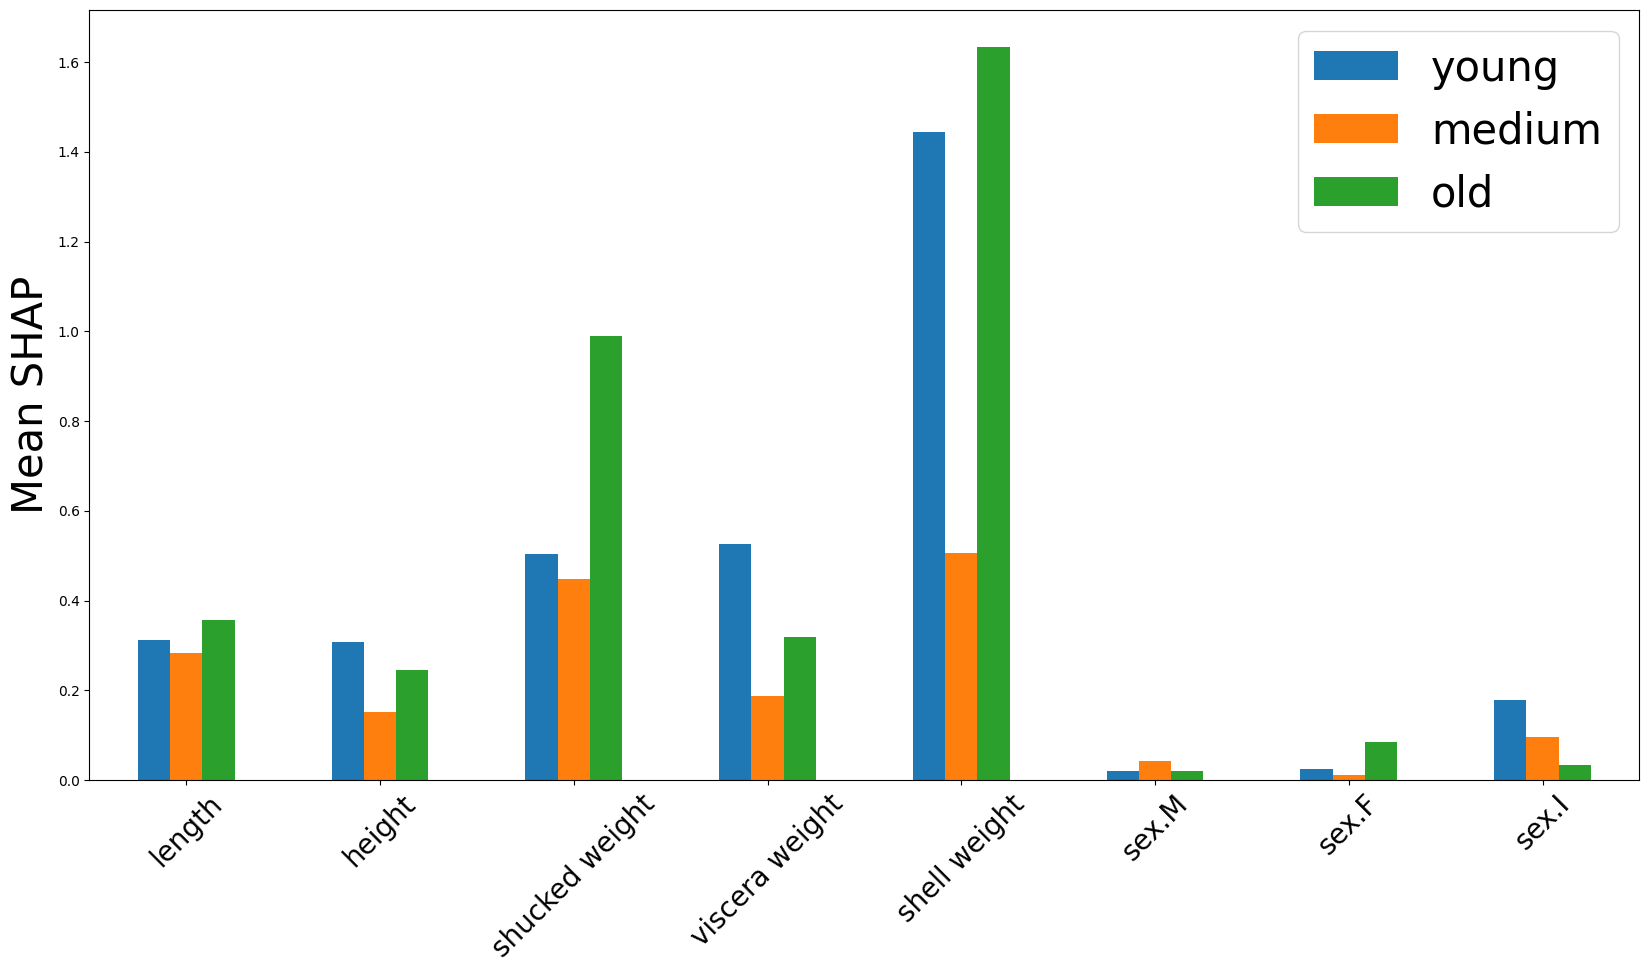

In [17]:
# Program wylicza średnie wartości SHAp dla każdej z klasy
mean_0 = np.mean(np.abs(shap_values_cat.values[:, :, 0]), axis=0)
mean_1 = np.mean(np.abs(shap_values_cat.values[:, :, 1]), axis=0)
mean_2 = np.mean(np.abs(shap_values_cat.values[:, :, 2]), axis=0)

df = pd.DataFrame({"young": mean_0, "medium": mean_1, "old": mean_2})

# Wykres średnich wartości SHAP (dla wszystkich obiektów i wszystkich klas)

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
df.plot.bar(ax=ax)

ax.set_ylabel("Mean SHAP", size=30)
ax.set_xticklabels(X.columns, rotation=45, size=20)
ax.legend(fontsize=30)

In [18]:
# Tworzenie wykresu wartości SHAP jedynie dla obiektów przewidzianej klasy
preds = model_cat.predict(X)

new_shap_values = []
for i, pred in enumerate(preds):
  new_shap_values.append(shap_values_cat.values[i][:, pred])

# replace shap values
shap_values_cat.values = np.array(new_shap_values)
print(shap_values_cat.shape)

(4177, 8)


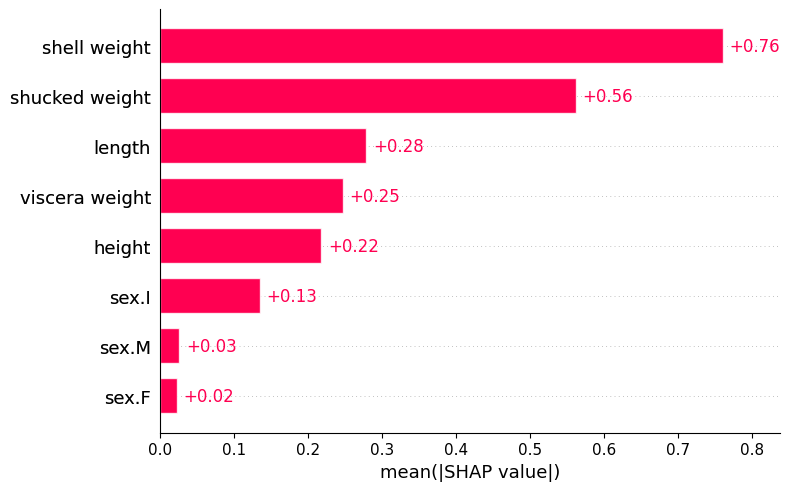

In [19]:
shap.plots.bar(shap_values_cat)

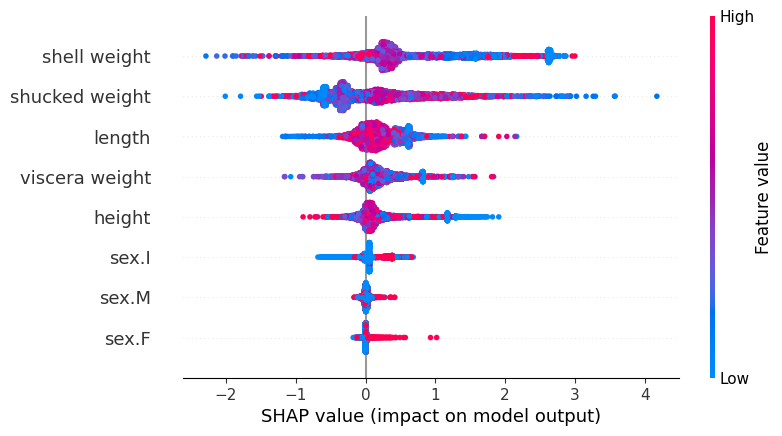

In [20]:
shap.plots.beeswarm(shap_values_cat)